# Regularization

## Code chương trước

In [1]:
# Download Data
import torch
import numpy as np
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# constant for classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

x = train_dataset.data
y = train_dataset.targets

# Reshape and cast the input data
x = x.view(-1, 784)
x = x.to(torch.float32)

# Cast the target labels to the 'long' data type
y = y.to(torch.long)

# Split data into train & valid set
from sklearn.model_selection import train_test_split

valid_pct = .2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_pct)

# Normalization
def min_max_scale(data, a=0, b=1):
    # Calculate the minimum and maximum values of the data
    data_min = data.min()
    data_max = data.max()

    # Perform Min-Max Scaling
    data_norm = (data - data_min) / (data_max - data_min)

    # Rescale the data to the [a, b] range
    data_norm = a + data_norm * (b - a)

    return data_norm

x_train_norm = min_max_scale(x_train)
x_valid_norm = min_max_scale(x_valid)

# Load data
from torch.utils.data import TensorDataset, DataLoader

def load_data(x_tensor, y_tensor, batch_size, test):
    data = TensorDataset(x_tensor, y_tensor)

    data_loader = DataLoader(data, batch_size=batch_size, shuffle=not test, drop_last=not test)

    print(f"Total Mini-Batches: {len(data_loader)}")
    for i, (x, y) in enumerate(data_loader):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    return data_loader

batch_size = 128
train_loader = load_data(x_train, y_train, batch_size=batch_size, test = False)
valid_loader = load_data(x_valid, y_valid, batch_size=batch_size, test=True)

Total Mini-Batches: 375
Shape of Each Mini-Batch: torch.Size([128, 784])

Total Mini-Batches: 94
Shape of Each Mini-Batch: torch.Size([128, 784])



Trong đoạn mã trên, tôi đã giữ y nguyên như đoạn code trong chương trước.

## GPU Implementation

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**CUDA** (Compute Unified Device Architecture): đề cập đến một nền tảng tính toán song song được phát triển bởi **NVIDIA**, một trong những nhà sản xuất card đồ họa và **GPU** lớn nhất trên thế giới. **CUDA** cho phép bạn sử dụng **GPU** (Graphics Processing Unit) của NVIDIA để thực hiện các tính toán không chỉ liên quan đến đồ họa, mà còn bao gồm các tác vụ tính toán tổng quát, bao gồm cả tính toán khoa học và máy học.

In [23]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Assume 3 hidden layers, each with 200 units
        self.input = nn.Linear(784, 200)
        self.hd1 = nn.Linear(200, 200)
        self.hd2 = nn.Linear(200, 200)
        self.hd3 = nn.Linear(200, 10)

        self.layers = [self.input, self.hd1, self.hd2]

    def forward(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer(x)
            # Apply ReLU Activation Function
            x = torch.relu(x)

        out = self.hd3(x)

        return out

def train_model(model, train_loader, valid_loader, \
                loss_fn, optimizer_algorithm, lr, n_epochs, device):

    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):

            ### New code
            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)
            ############

            out = model.forward(x)

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):

                    ### New code
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)
                    ##########

                    out = model.forward(x)

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [24]:
model = Model()

### New code
# Conver model to GPU
model = model.to(device)
model
################

Model(
  (input): Linear(in_features=784, out_features=200, bias=True)
  (hd1): Linear(in_features=200, out_features=200, bias=True)
  (hd2): Linear(in_features=200, out_features=200, bias=True)
  (hd3): Linear(in_features=200, out_features=10, bias=True)
)

Chuyển đổi dữ liệu sang GPU là một quá trình đơn giản, tương tự việc bạn giao bài tập cho người bạn giỏi để làm giúp. Khi bạn đưa dữ liệu lên GPU, đó là như bạn đang sử dụng sức mạnh tính toán của GPU để thực hiện các phép tính. Khi bạn muốn sử dụng kết quả, bạn có thể dễ dàng đưa dữ liệu từ GPU trở lại CPU, giống như việc bạn lấy bài tập đã làm xong từ người bạn học giỏi để nộp cho giáo viên vậy.

In [25]:
import time
# Get the start time
start_time = time.time()

# Define the loss function (CrossEntropyLoss) and optimizer algorithm (Adam)
loss_fn = nn.CrossEntropyLoss()
optimizer_algorithm = "Adam"

# Set the learning rate and number of training epochs
learning_rate = 0.01
n_epochs = 5

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             loss_fn, \
                                                             optimizer_algorithm, \
                                                             learning_rate, \
                                                             n_epochs, \
                                                             device)

# Get the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Convert to minutes and seconds
execution_time_minutes = int(execution_time // 60)
execution_time_seconds = round(execution_time % 60, 2)

print(f"Model training time: {execution_time_minutes} min {execution_time_seconds}s")

Model training time: 4 min 56.14s


Như bạn có thể thấy, tôi đã đơn giản là sao chép code từ chương trước và chỉ thêm vài dòng code mới để chuyển x, y và model sang GPU. Nhưng điều đáng chú ý là thời gian huấn luyện mô hình đã giảm gần như một nửa. Điều này cho thấy sức mạnh của việc sử dụng GPU trong Deep Learning.

Trước đây, khi thực hiện huấn luyện mô hình trên CPU, quá trình này thường mất rất nhiều thời gian. Nhưng với sự hỗ trợ của GPU, các phép tính toán được thực hiện nhanh chóng hơn nhiều lần, giúp cho việc phát triển Deep Learning trở nên mạnh mẽ và hiệu quả hơn.





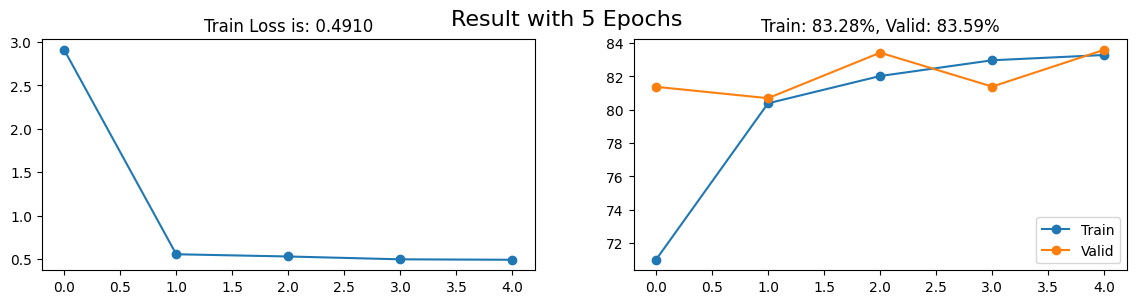

In [26]:
import matplotlib.pyplot as plt

final_loss = losses.mean(1)[-1]
final_train_acc = train_acc.mean(1)[-1]
final_valid_acc = valid_acc.mean(1)[-1]

fig, axs = plt.subplots(1, 2, figsize = (14, 3))

axs[0].plot(range(losses.shape[0]), losses.mean(1), "-o")
axs[0].set_title(f"Train Loss is: {final_loss:.4f}")


axs[1].plot(range(train_acc.shape[0]), train_acc.mean(1), "-o")
axs[1].plot(range(valid_acc.shape[0]), valid_acc.mean(1), "-o")
axs[1].set_title(f"Train: {final_train_acc:.2f}%, Valid: {final_valid_acc:.2f}%")
axs[1].legend(["Train", "Valid"])

plt.suptitle(f"Result with {n_epochs} Epochs", fontsize = 16)
plt.show()

Như bạn có thể thấy, những gì tôi vừa thực hiện đơn giản chỉ là việc di chuyển dữ liệu x, y và mô hình sang GPU để tận dụng sức mạnh tính toán của nó. Phần còn lại chỉ đơn giản là sao chép code từ chương trước, vì vậy kết quả mà chúng ta thu được khá tương đồng.

Bây giờ, hãy cùng tôi khám phá các kỹ thuật regularization để cải thiện độ chính xác của mô hình.

Regularization là tập hợp các kỹ thuật được sử dụng trong deep learning để đảm bảo mô hình học từ dữ liệu một cách tổng quát hơn, thay vì chỉ học thuộc lòng các ví dụ cụ thể. Để hình dung điều này, hãy tưởng tượng bạn nhận được một đề cương ôn thi từ giáo viên. Thay vì chỉ đọc đáp án của đề cương mà không hiểu tại sao đáp án đó lại đúng, regularization giống như việc bạn muốn hiểu sâu hơn về nguyên tắc và kiến thức chung, giúp bạn tự tin giải quyết các câu hỏi khác nhau khi đi thi.

Có 3 loại Regularization phổ biến trong Deep Learning đó là:

- Dropout

- L2 Regularization

- Batch Normalization






## Dropout

In [ ]:
import torch.nn as nn

dropout_rate = 0.6

dropout_layer = nn.Dropout(p=dropout_rate)

Dropout là một trong những kỹ thuật regularization phổ biến trong mạng neural. Bạn có thể tưởng tượng nó như việc đôi khi bạn "ẩn đi" một số phần kiến thức quan trọng trong sách giáo trình. Điều này đặt ra một thách thức cho bạn, buộc bạn phải học và hiểu sâu hơn về nguyên tắc tổng quan của chủ đề, thay vì chỉ ghi nhớ các chi tiết cụ thể. Khi bạn đối mặt với các tình huống mới, khả năng tổng quan hóa và sáng tạo của bạn được thúc đẩy. Tương tự, trong mạng neural, dropout là việc tắt ngẫu nhiên một số neuron trong các lớp ẩn, làm cho mô hình không thể quá phụ thuộc vào các neuron cụ thể. Kỹ thuật này giúp mô hình học được các đặc trưng tổng quan của dữ liệu và tạo ra một mô hình khái quát hóa tốt hơn.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        ### New Code
        # Droput Rate
        self.dropout_rate = dropout_rate
        #########

        # Assume 3 hidden layers, each with 200 units
        self.input = nn.Linear(784, 200)
        self.hd1 = nn.Linear(200, 200)
        self.hd2 = nn.Linear(200, 200)
        self.hd3 = nn.Linear(200, 10)

        self.layers = [self.input, self.hd1, self.hd2]

    def forward(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer(x)
            # Apply ReLU Activation Function
            x = torch.relu(x)

            ### New Code
            # Add droput to hidden layer
            x = F.dropout(x, self.dropout_rate, training=self.training)
            ##################

        out = self.hd3(x)

        return out

def train_model(model, train_loader, valid_loader, \
                loss_fn, optimizer_algorithm, lr, n_epochs, device):

    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):

            ### New code
            # Set Model to train mode
            model.train()
            ######

            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)

            out = model.forward(x)

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            ### New code
            # Set Model to evaluation mode
            model.eval()
            ######

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)

                    out = model.forward(x)

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [33]:
n_epochs = 1
dropout_rate = .5
model = Model(dropout_rate).to(device)


parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             loss_fn, \
                                                             optimizer_algorithm, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device)

Khi sử dụng Dropout trong mô hình, ta cần thêm hai dòng mã để xác định mô hình đang ở chế độ huấn luyện (train mode) hoặc chế độ đánh giá (evaluation mode). Điều này quan trọng vì Dropout nên chỉ được áp dụng trong quá trình huấn luyện mô hình mà không nên ảnh hưởng đến quá trình đánh giá mô hình với dữ liệu kiểm tra.

Cũng giống như việc bạn đang ôn tập để cương. Trong quá trình ôn, bạn có thể tạm thời che đi một số thông tin hoặc ẩn đi các đáp án cụ thể để hiểu rõ hơn về chủ đề. Nhưng khi bạn bước vào kỳ thi, bạn không cần che giấu hoặc ẩn đi bất kỳ thông tin nào nữa. Lúc này, bạn cần sử dụng tất cả kiến thức mà bạn đã học để cố gắng đạt được điểm cao nhất.

Tương tự, trong mô hình neural, việc sử dụng Dropout trong quá trình huấn luyện giống như việc "che đi" một số kết nối ngẫu nhiên để ngăn chặn overfitting. Nhưng khi mô hình được đánh giá với dữ liệu kiểm tra, không cần áp dụng Dropout nữa, và mô hình sử dụng toàn bộ kiến thức để đưa ra dự đoán tốt nhất.

## L2 Regularization

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Assume 3 hidden layers, each with 200 units
        self.input = nn.Linear(784, 200)
        self.hd1 = nn.Linear(200, 200)
        self.hd2 = nn.Linear(200, 200)
        self.hd3 = nn.Linear(200, 10)

        self.layers = [self.input, self.hd1, self.hd2]

    def forward(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer(x)
            # Apply ReLU Activation Function
            x = torch.relu(x)

        out = self.hd3(x)

        return out

def train_model(model, train_loader, valid_loader, \
                loss_fn, optimizer_algorithm, lr, n_epochs, device, weight_decay):

    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)

    ### New code
    # L2 regularization
    optimizer = opt_fn(model.parameters(), lr=lr, weight_decay = weight_decay)
    #####

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):
            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)

            out = model.forward(x)

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)

                    out = model.forward(x)

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [37]:
n_epochs = 1
weight_decay = .0001

model = Model().to(device)

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             loss_fn, \
                                                             optimizer_algorithm, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device, \
                                                             weight_decay)

Công thức L2 regularization được sử dụng để kiểm soát giá trị tuyệt đối của trọng số (weight) trong mô hình và thêm nó vào hàm mất mát (loss). Công thức này có dạng:

$$
L2\_Loss = \frac{\lambda}{2} \sum_{i=1}^{n} w_i^2
$$

Trong đó:
- ${\lambda}$: là tham số "weight decay" (điều chỉnh mức độ của regularization).

- ${n}$ là số lượng trọng số (weight) trong mô hình.

- ${w_i}$ là trọng số thứ $i$ của mô hình.


L2 regularization sẽ thêm một tham số gọi là "weight decay" vào hàm mất mát (loss function) của mô hình. Thay vì để mô hình tự do tạo ra các trọng số có giá trị lớn và phức tạp, L2 regularization áp đặt một giới hạn để kiểm soát giá trị tuyệt đối của chúng.

Hãy tưởng tượng rằng bạn đang ôn thi và cần học một đề cương phức tạp. Thay vì nỗ lực học thuộc lòng từng phần chi tiết của đề cương, bạn quyết định tập trung vào các khái niệm và nguyên tắc tổng quan. Bạn thiết lập một giới hạn cho mức độ chi tiết bạn nên nắm vững, giúp bạn hiểu sâu hơn về chủ đề mà không bị lạc hướng vào những thông tin không quan trọng. Tương tự, L2 regularization giúp mô hình tập trung vào các đặc trưng quan trọng và kiểm soát sự phụ thuộc vào những chi tiết không cần thiết, đồng thời giúp ngăn chặn hiện tượng overfitting (học thuộc lòng đáp án) trong quá trình học.

## Batch Normalization

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Assume 3 hidden layers, each with 200 units
        self.input = nn.Linear(784, 200)
        self.hd1 = nn.Linear(200, 200)
        self.hd2 = nn.Linear(200, 200)
        self.hd3 = nn.Linear(200, 10)

        ### New Code
        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(200)
        self.bn2 = nn.BatchNorm1d(200)

        self.layers = [self.input, self.bn1,self.hd1, self.bn2, self.hd2]
        #########

    def forward(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer(x)
            # Apply ReLU Activation Function
            x = torch.relu(x)

        out = self.hd3(x)

        return out

def train_model(model, train_loader, valid_loader, \
                loss_fn, optimizer_algorithm, lr, n_epochs, device):

    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):
            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)

            out = model.forward(x)

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)

                    out = model.forward(x)

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [41]:
n_epochs = 1
model = Model().to(device)

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             loss_fn, \
                                                             optimizer_algorithm, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device)

![](Images/batch_normalization.png)

Batch Normalization (BatchNorm) là một kỹ thuật quan trọng trong deep learning. Nó ra đời để giải quyết vấn đề trong quá trình huấn luyện mô hình, khi đầu ra của các lớp ẩn có thể trở nên quá lớn hoặc quá nhỏ, gây khó khăn cho quá trình học của mô hình. BatchNorm thực hiện chuẩn hóa đầu ra của các lớp ẩn, bằng cách đảm bảo rằng giá trị trung bình gần bằng 0 và độ lệch chuẩn gần bằng 1, ngay cả khi dữ liệu đầu vào không tuân theo phân phối chuẩn (Gaussian distribution).

Ví dụ: Trong mạng neural thông thường, đầu ra của các lớp ẩn có thể thay đổi theo từng mini-batch của dữ liệu huấn luyện. BatchNorm đảm bảo rằng các đầu ra này có giá trị trung bình gần bằng 0 và độ lệch chuẩn gần bằng 1, giúp mô hình học nhanh hơn và ổn định hơn.

Một điểm quan trọng cần lưu ý là BatchNorm không thường được sử dụng ở lớp ẩn cuối cùng trước khi đầu ra được đưa qua trọng số của lớp output (chỗ được đúng khung màu xanh dương). Điều này giúp duy trì tính tự nhiên của đầu ra của mô hình trong các tác vụ như phân loại, trong đó phân phối của đầu ra có thể không cần phải được chuẩn hóa.

Tóm lại, Batch Normalization chuẩn hóa đầu ra của các lớp ẩn trong mô hình, đảm bảo rằng chúng luôn có giá trị trung bình gần bằng 0 và độ lệch chuẩn gần bằng 1. Điều này giúp tăng tốc quá trình huấn luyện và làm cho mô hình ổn định hơn trong deep learning.

## Kết hợp tất cả lại với nhau

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        ### New Code
        # Droput Rate
        self.dropout_rate = dropout_rate
        #########

        # Assume 3 hidden layers, each with 200 units
        self.input = nn.Linear(784, 200)
        self.hd1 = nn.Linear(200, 200)
        self.hd2 = nn.Linear(200, 200)
        self.hd3 = nn.Linear(200, 10)

        ### New Code
        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(200)
        self.bn2 = nn.BatchNorm1d(200)

        self.layers = [self.input, self.bn1,self.hd1, self.bn2, self.hd2]
        #########

    def forward(self, x):
        # Forward pass
        for layer in self.layers:
            x = layer(x)
            # Apply ReLU Activation Function
            x = torch.relu(x)

            ### New Code
            # Add droput to hidden layer
            x = F.dropout(x, self.dropout_rate, training=self.training)
            ##################

        out = self.hd3(x)

        return out

def train_model(model, train_loader, valid_loader, \
                loss_fn, optimizer_algorithm, lr, n_epochs, device, weight_decay):

    # Get the optimizer function based on the provided algorithm name
    opt_fn = getattr(torch.optim, optimizer_algorithm)

    ### New code
    # L2 regularization
    optimizer = opt_fn(model.parameters(), lr=lr, weight_decay = weight_decay)
    #####

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):

            ### New code
            # Set Model to train mode
            model.train()
            ######

            # Convert x, y to GPU
            x = x.to(device)
            y = y.to(device)

            out = model.forward(x)

            # Calculate loss
            loss = loss_fn(out, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y).float().mean()
            train_acc[epoch, i] = acc

            ### New code
            # Set Model to evaluation mode
            model.eval()
            ######

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):
                    # Convert x, y to GPU
                    x = x.to(device)
                    y = y.to(device)

                    out = model.forward(x)

                    acc = 100 * (out.argmax(1) == y).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [55]:
import time
# Get the start time
start_time = time.time()

n_epochs = 5
droput_rate = .1
weight_decay = .0001

model = Model(droput_rate).to(device)

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             loss_fn, \
                                                             optimizer_algorithm, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device, \
                                                             weight_decay)

# Get the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Convert to minutes and seconds
execution_time_minutes = int(execution_time // 60)
execution_time_seconds = round(execution_time % 60, 2)

print(f"Model training time: {execution_time_minutes} min {execution_time_seconds}s")

Model training time: 5 min 33.93s


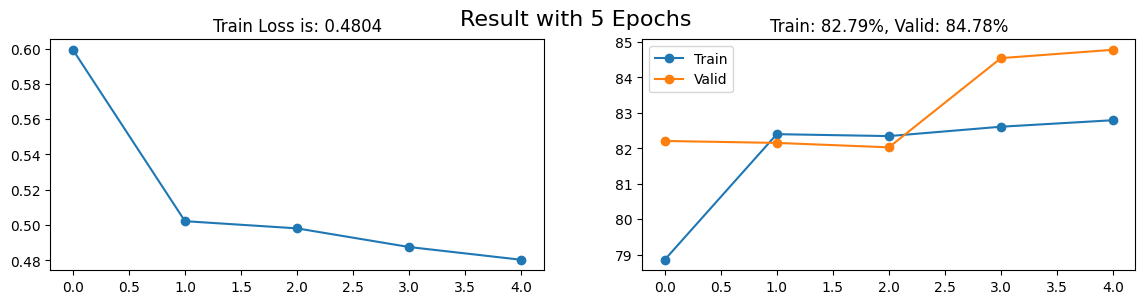

In [56]:
import matplotlib.pyplot as plt

final_loss = losses.mean(1)[-1]
final_train_acc = train_acc.mean(1)[-1]
final_valid_acc = valid_acc.mean(1)[-1]

fig, axs = plt.subplots(1, 2, figsize = (14, 3))

axs[0].plot(range(losses.shape[0]), losses.mean(1), "-o")
axs[0].set_title(f"Train Loss is: {final_loss:.4f}")


axs[1].plot(range(train_acc.shape[0]), train_acc.mean(1), "-o")
axs[1].plot(range(valid_acc.shape[0]), valid_acc.mean(1), "-o")
axs[1].set_title(f"Train: {final_train_acc:.2f}%, Valid: {final_valid_acc:.2f}%")
axs[1].legend(["Train", "Valid"])

plt.suptitle(f"Result with {n_epochs} Epochs", fontsize = 16)
plt.show()

Trong tập dữ liệu kiểm tra (validation set), kết quả đã có một chút sự cải thiện, nhưng không quá đáng kể, vẫn giữ trong khoảng từ 80 đến 85%. Bây giờ chúng ta cùng xem liệu kết quả trên tập dữ liệu kiểm tra (test set) có cao hơn không nhé!

In [57]:
x_test = test_dataset.data
y_test = test_dataset.targets

# Reshape and cast the input data
x_test = x_test.view(-1, 784)
x_test = x_test.to(torch.float32)

# Cast the target labels to the 'long' data type
y_test = y_test.to(torch.long)

In [58]:
model.eval()
out = model.forward(x_test.to(device)).cpu()
model.train()

test_acc = 100 * (out.argmax(1) == y_test).float().mean()

ids_error = (out.argmax(1) != y_test).nonzero()
print(f"In {len(y_test)} images, model guess wrong {len(ids_error)}")
print(f"Accuracy is: {test_acc:.2f}%")

In 10000 images, model guess wrong 1608
Accuracy is: 83.92%


Kết quả đã có sự cải thiện một chút, tuy không đáng kể, vẫn trong khoảng từ 80 đến 85%. Tuy nhiên, để đạt được độ chính xác cao hơn 85%, chúng ta sẽ bước vào một chương mới đầy hứng thú với sự xuất hiện của Convolutional Neural Network (CNN). CNN là một công cụ mạnh mẽ, được thiết kế đặc biệt cho việc xử lý và phân loại hình ảnh. Hãy cùng chờ xem liệu CNN có thể đáp ứng mong đợi của chúng ta không nhé!

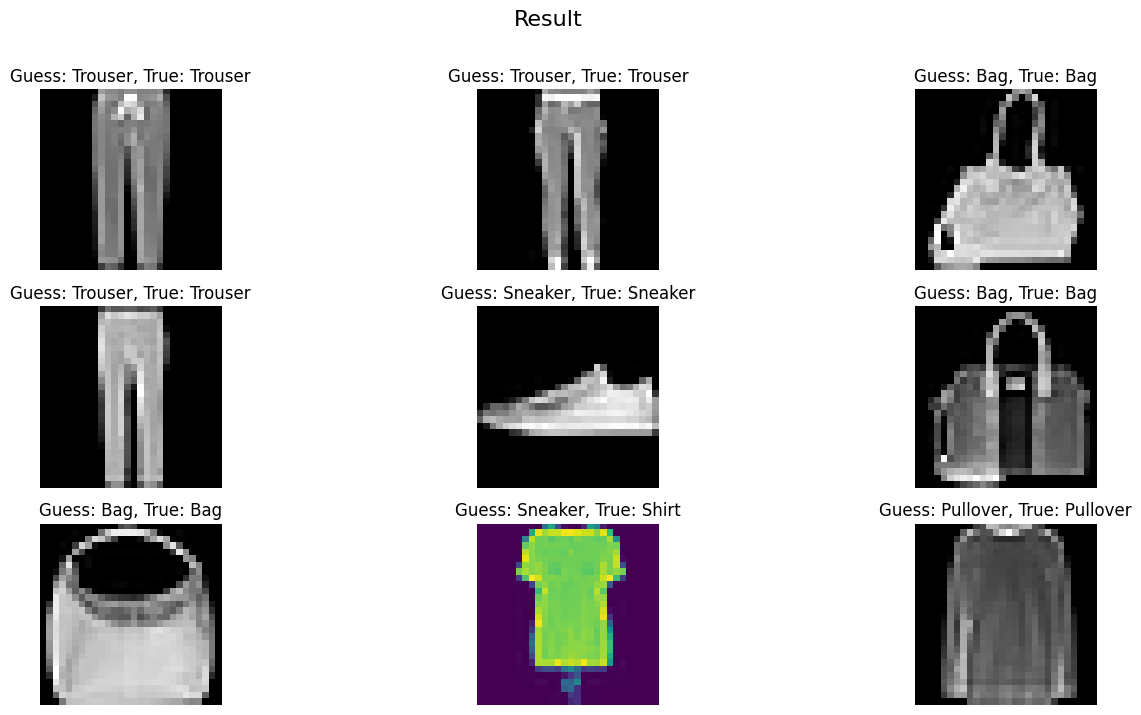

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))

for ax in axs.flatten():
    # Select a random index from the output
    random_index = np.random.choice(len(out))

    # Display the image at the selected index with colormap gray for correct predictions
    true_label = y_test[random_index]
    guess_label = out.argmax(1)[random_index]

    if true_label == guess_label:
        ax.imshow(x_test[random_index].view(28, 28), cmap="gray")
    else:
        ax.imshow(x_test[random_index].view(28, 28))


    ax.set_title(f"Guess: {classes[guess_label]}, True: {classes[true_label]}")
    ax.axis("off")

plt.suptitle("Result", fontsize=16)
plt.show()